## Intro

We are going to use pillow (Python Imaging Library/PIL fork) to correct some black and white icon images that don't have the specifications we need.  This is a toy project.  In broad strokes, we need to:

-  Rotate the images to the correct orientation
-  Resize them
-  Convert them from tiff to jpeg format.  

*(Note for the future:  A jpeg file type will require the images to be in 'L', 'RGB', or 'CMYK' modes.  More on this later.)*

I'm starting with no knowledge of the pillow imaging package and very little expertise in image files.  

Obviously, the first things I tried were the simplest methods to execute the above.  Pillow is a big package and has functions to rotate, resize, and convert images.  However, a lot of the images looked like hot garbage after doing this!

To find out why, let's get started by poking around our image files and gathering some detailed info.

## Exploration

In [42]:
from PIL import Image, ImageOps, ImageChops
from os import path
from glob import glob

In [43]:
def has_bad_extrema(img):
    #Compare image pixel extrema to their full mode bit depth
    #flag if pixels use < half of the full depth/range avail

    #Note: assumes images are 8-bit or binary, which my test images are
    
    mode = img.mode
    extra = img.getextrema()

    full = 255
    if len(mode) > 1:
        #multiband image has extrema for each band
        depth = 0
        for i in range(len(extra)):
            #get the max range out of all bands
            depth = max(extra[i][1] - extra[i][0], depth)
    else:
        #single band image
        depth = extra[1] - extra[0]
        if mode == '1':
            #1-bit mode, range of 0-1
            full = 1
    if (depth < 0.5*full) or (depth > full):
        #images use less than half or more than max bit depth
        return True
    return False

In [44]:
dir = '../images/'
pattern = 'ic*dp'
image_list = [path.abspath(x) for x in glob(dir + pattern)]
img_types = {}
sus_imgs = []

#Poke around in these image files and see what's what
for file in image_list:
    img = Image.open(file)
    mode = img.mode
    img_types.update({mode : img_types.get(mode, 0) + 1})
    if has_bad_extrema(img):
        sus_imgs.append(path.basename(file))
        print(f'Image may have problematic contrast levels: {path.basename(file)}')
        print(f'Image mode: {img.mode}')
        print(f'Image extrema: {img.getextrema()}')
        print(f'Image histogram: {img.histogram()}')
        print(f'Other image info: {img.info}\n')

Image may have problematic contrast levels: ic_local_convenience_store_white_48dp
Image mode: 1
Image extrema: (0, 255)
Image histogram: [19840, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17024]
Other image info: {'compression': 'raw', 'dpi': (1, 1), 'resolution': (1, 1)}

Image m

In [45]:
#Summary of info
sus_imgs.sort()
print (f'Image files to inspect:')
print ("\n".join(sus_imgs))
print(f'\nOverall statistics of our image modes: {img_types}')

Image files to inspect:
ic_local_convenience_store_black_48dp
ic_local_convenience_store_white_48dp
ic_local_movies_black_48dp
ic_local_movies_white_48dp

Overall statistics of our image modes: {'LA': 96, '1': 2, 'P': 2}


Our code has found 4 images that might be problematic in terms of their pixel values and their mode.  

The image mode defines the type (number of bits) and depth (range/extrema of pixel values, sometimes given in bits) for pixels in the image.  This is independent of the image file format, which may or may not be compatible with certain image modes.

Two images are black icons in palette ('P') mode, which is an 8-bit mode, however their pixel values are binary with a range of only [0, 1].   To a layman like me they look like they are meant to be 1-bit/binary mode images but aren't for some reason.  Or, they should have a palette associated with them that converts 0 and 1 to 0 (black) and 255 (white).  When displayed, they don't look great:

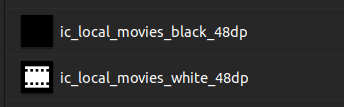  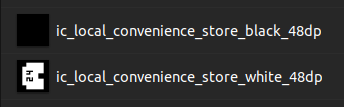


Two images are white icons in 1-bit ('1') mode, however their pixel values are binary (good) with a range of [0, 255] (bad).  In other words, they look like they are binary images but somehow their pixel values are out of the allowed range of [0, 1] for that mode. 

The white icons seem to display ok, but we should make sure they still look ok after our conversion process:

### Test Conversion for Odd 1-Bit Images

In [ ]:
#test conversion on a '1' mode images
#displays the result!
file = '../images/ic_local_movies_white_48dp'
tmp_file = './tmp_movies_white'
img = Image.open(file).convert('L').rotate(270).save(tmp_file, 'jpeg')
img = Image.open(tmp_file)
print(f'Image mode: {img.mode}')
print(f'Image extrema: {img.getextrema()}')
img.show()

Image mode: L
Image extrema: (0, 255)


Opening in existing browser session.


/snap/core20/current/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /lib/x86_64-linux-gnu/libproxy.so.1)
Failed to load module: /home/lilli/snap/code/common/.cache/gio-modules/libgiolibproxy.so


Good news.  It looks like our 'suspicious' white icons in 1-bit mode will convert just fine.

### Discussion of Odd 'P' Mode Images

Let's look more at the two black icons in 'P' mode with pixel values from [0, 1].

If they were in 1-bit mode, our image viewer might know what to make of them.  As is, they appear solid black even though there should be more information there.

Looking at their details in Image Magick, they are being recognized as 8-bit, palette images, but the histogram is different.  Image Magick's histogram reports a uniformly flat (solid black) image.  This suggests to me that Image Magick does some conversion on the image, probably/hopefully based on the defined palette for the image.

Quoting pillow documentation, 'The palette mode (P) uses a color palette to define the actual color for each pixel.'  So, it seems to me that this image would be displaying fine if the palette was mapping 0 to black and 1 to white, or vise versa, but it isn't.

*I say this all with the benefit of hindsight.  I took some time to synthesize this information.  I thought it was more likely there was a file mode/type/unknown conflict that was creating an issue.*

#### A Digression

What follows is a code snippet to preserve some things I tried that didn't work. 

This is a [useful StackOverflow answer](https://stackoverflow.com/questions/52307290/what-is-the-difference-between-images-in-p-and-l-mode-in-pil) about images and pillow.  There is a lot I could try.  One simple thing to put here as an example -- they recommend converting the image in the same step as opening the file.  

As you can see from running the same conversion steps as for the white icon images above (in the code section below), no dice.  I also tried several file/mode combinations, including leaving the conversion mode to be determined by pillow.  What I found was that unless I convert from the existing 'P' mode to 'P' mode, which unsurprisingly had no benefit, the image gets flattened to a pixel range of [0, 0] (just as in Image Magick).  Information destroyed.

Take a look:

In [ ]:
#test conversion on a flagged black icon image
#displays the result!
file = '../images/ic_local_movies_black_48dp'
tmp_file = './tmp_movies_black'
img = Image.open(file)
print('BEFORE converting to L mode')
print(f'Image mode: {img.mode}')
print(f'Image extrema: {img.getextrema()}\n')

img = Image.open(file).convert("L").rotate(270).save(tmp_file, 'jpeg')

img = Image.open(tmp_file)
print('AFTER')
print(f'Image mode: {img.mode}')
print(f'Image extrema: {img.getextrema()}')
img.show()

BEFORE converting to L mode
Image mode: P
Image extrema: (0, 1)

AFTER
Image mode: L
Image extrema: (0, 0)


Opening in existing browser session.


/snap/core20/current/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /lib/x86_64-linux-gnu/libproxy.so.1)
Failed to load module: /home/lilli/snap/code/common/.cache/gio-modules/libgiolibproxy.so
[24809:24809:0100/000000.696772:ERROR:zygote_linux.cc(672)] write: Broken pipe (32)


I did quite a bit of online research and trial and error working with pillow before I thought to track it in a Jupyter notebook.

This included playing around with trying to define a palette that would map these images correctly, but it didn't fix my image issues.  (I wasn't doing it right).

This is getting even deeper into the technical details of image data and manipulation, which could be time consuming -- this project shouldn't need me to reinvent the wheel and figuring out how to correctly adjust image palettes seemed like reinventing the wheel for the level of understanding I had at the time.

*An aside:*

*I actually did go back and get palette fiddling working.  You can see the results in my addendum at the end.  However, I solved this problem another way first, so I'm going to show that next.*

### Test Conversion of Odd Palette Images

Fortunately, I can think of alternative solutions:
-  Toss the black icon images.  Use the white icons, which should be identical in form, and reverse the colors.
-  Mathematically scale the pixel values to use the mode's full pixel range.  This can be done without using a palette.

Here's some code to do the latter:

In [63]:
#test conversion on a flagged black icon image
#displays the result!

def scale_palpixels(myImage, dmin, dmax):
    #rescale odd 'P' mode images
    #the P mode images in this data set have a pixel range [0, 1]
    data = myImage.getdata()
    myImage.putdata(data, scale=-255, offset=255)
    return myImage

file = '../images/ic_local_movies_black_48dp'
tmp_file = './tmp_movies_black'

img = Image.open(file)
depth = img.getextrema()
img = scale_palpixels(img, depth[0], depth[1])
img.convert("L").rotate(270).save(tmp_file, 'jpeg')
img = Image.open(tmp_file)
img.show()



/snap/core20/current/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /lib/x86_64-linux-gnu/libproxy.so.1)
Failed to load module: /home/lilli/snap/code/common/.cache/gio-modules/libgiolibproxy.so
[22065:22065:0100/000000.288754:ERROR:zygote_linux.cc(672)] write: Broken pipe (32)


Opening in existing browser session.


Looks good! 

 We've scaled the pixels so they now span the full mode depth and the image looks like a nice and clear icon now.  It happens that scaling the values by a factor of 255 resulted in a white icon on a black background instead of a black icon, so I had to reverse the colors (map 0 --> 255 and 1 --> 0).

### Discussion of 'LA' Mode Images

Now, let's finally take a look at the bulk of our images.


In [30]:
print("Image mode statistics:")
print(img_types)

Image mode statistics:
{'LA': 96, '1': 2, 'P': 2}



Most of our tiff images are in 'LA' mode.  This indicates an 8-bit greyscale 'Luminance' image with a additional alpha layer.  The alpha layer/band is a transparency mask.

(Remember that note at the beginning on jpeg compatibility?  Our options are 'RGB', 'L', and 'CMYK'.  Not 'LA'.)  

Pillow uses 'A' in the mode designation to indicate an alpha mask/transparency layer.  Sometimes images have a single, designated pixel value that indicates transparency.  This is indicated by the 'transparency' attribute in img.info for '1', 'L', 'I' or 'P' modes type images in pillow.  (Don't worry, we checked our image info on our rogue 'P' and '1' images above and they didn't have a transparency attribute.)

At minimum we'll have to convert our image from 'LA' to 'L' mode to be able to save them in jpeg format, but it's not clear yet how/if we'll need to adjust for the existing alpha channel in our images.  

Always try the fast/dumb thing that might work first!  As it turns out, if we attempt a straightforward conversion from 'LA' to 'L' mode, the output is less than desirable.  

Presuming that all our 'LA' images are similarly constructed, I've picked one set of black and white icons to analyze:

In [89]:
#test conversion from 'LA' to 'L' mode
#uncomment the .show() lines to see a bigger version of an image
#if showing mult images they can be displayed out of order
file_w = '../images/ic_directions_bike_white_48dp'
file_b = '../images/ic_directions_bike_black_48dp'
tmp_w = './tmp_bike_white'
tmp_b = './tmp_bike_black'

#white icon
#img = Image.open(file_w).show()
img = Image.open(file_w).convert('L').save(tmp_w, 'jpeg')
#img = Image.open(tmp_w).show()

#black icon
#img = Image.open(file_b).show()
img = Image.open(file_b).convert('L').save(tmp_b, 'jpeg')
#img = Image.open(tmp_b).show()



Here's our before (left) and after (right) conversion to 'L' mode in the code block above:

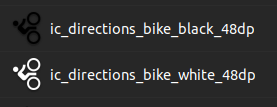  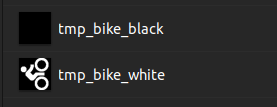

That transparency layer was doing some heavy lifting.  Let's poke around some more.



Histogram data in pillow can be misleading because it often needs to be truncated for the multiple bands.  I'm going to split the bands and look at them individually and see if that gives me some insight.

#### Converting the Black 'LA' Images

In [90]:
#Looking at the black icon first
#I will sometimes redefine files in a new code block
#'unnecessarily', for clarity purposes
file_b = '../images/ic_directions_bike_black_48dp'

img = Image.open(file_b)
L, alpha = img.split()
print('BLACK ICON')
print(f'Image extrema: {img.getextrema()}')
print(f'L-band histogram: {L.histogram()}')
print(f'Alpha-band histogram: {alpha.histogram()}')
#L.show()
#alpha.show()

BLACK ICON
Image extrema: ((0, 0), (0, 255))
L-band histogram: [36864, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Alpha-band histogram: [25078, 59, 36, 39, 103, 35, 32, 29, 24, 27, 33, 23, 10, 8, 9, 16, 30, 28, 57, 55, 43, 32, 24, 11, 37, 52, 8, 6, 23, 13, 31, 22, 15, 18, 6, 11

Interesting.

Looking at the black icon, the L-band for this image is a flat (solid black).  The alpha layer is providing all of the detail.


##### Transparency and Alpha Composites
Alpha layers/masks control or describe the transparency/opacity of the color bands of the image.  The, say, RGB components give the color of the pixel, without any reference to opacity.  When combined with an alpha layer, a '0' value in the alpha layer means that the color is fully transparent/invisible.  A '1', on a normalized scale, or '255' in an 8-bit image, indicates that the color bands are fully opaque.

We can confirm we have this right by looking at a few pixel values.  Our image is fully transparent at the edges and if we look at the pixel values for the coordinates (0, 0) in our image we get:


In [91]:
file_b = '../images/ic_directions_bike_black_48dp'
img = Image.open(file_b)
print(img.getpixel((0, 0)))

(0, 0)


L band = 0 (black)

A band = 0 (make this color fully transparent)


 Our alpha layer makes the flat black 'L' layer fully opaque where the bike is, partially transparent on the boundaries of the bike (creating a smoothed edge appearance), and fully transparent elsewhere.  This creates the effect of a black bike on an fully transparent or invisible background.

 Our final image won't be able to support any transparency, so we need to convert the 'invisible' background to a white one for our black icon.  I first did this using the *alpha_composite()* method.
 

 **alpha_composite(im1, im2)** - alpha composite im2 over im1.  Must be in RGBA mode.  In other words, paste im2 over im1, interpolating between them with the alpha layer.  
 
 In this case, we want im2 to be our original image and im1 to be our new background color.  Since we have a black icon, we want to composite it with a white background.  An alpha composite is an image manipulation term, with a [pretty good wikipedia page](https://en.wikipedia.org/wiki/Alpha_compositing).  
 
 If I understand correctly, this alpha_composite method will do the same linear interpolation between our white background and black image, using the alpha layer in our image as the transparency mask between the two.  The math is similar to:

 out = image1 * (1.0 - alpha) + image2 * alpha

where, in our case, alpha varies by pixel, and where I'm being sloppy about indicating which bands are included and what they look like in image1 and image2.

There is also a *composite()* method in pillow, where two images are blended using a transparency mask.  The way I'll be doing things, I think both of these methods should give the same results.  Let's try them out.

In [92]:
#try alpha comp and comp methods on 'LA' image
#shows the result!
file_b = '../images/ic_directions_bike_black_48dp'
file_bac = './tmp_bike_bac'
file_bc = './tmp_bike_bc'

img = Image.open(file_b).convert('RGBA')
white_mask = Image.new("RGBA", img.size, (255,255,255))

#make alpha_composite
Image.alpha_composite(white_mask, img).save(file_bac, 'tiff')

#make composite
img = Image.open(file_b) #leaving in 'LA' mode
Image.composite(img.getchannel('L'), white_mask, img.getchannel('A')).save(file_bc, 'tiff')

img = Image.open(file_bac).show()
img = Image.open(file_bc).show()

/snap/core20/current/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /lib/x86_64-linux-gnu/libproxy.so.1)
Failed to load module: /home/lilli/snap/code/common/.cache/gio-modules/libgiolibproxy.so
/snap/core20/current/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /lib/x86_64-linux-gnu/libproxy.so.1)
Failed to load module: /home/lilli/snap/code/common/.cache/gio-modules/libgiolibproxy.so


Opening in existing browser session.
Opening in existing browser session.


These look good. 

In [93]:
#compare alpha_composite and composite results
#difference() will create an image of the abs val of their pixel diff
img_bac = Image.open(file_bac)
img_bc = Image.open(file_bc)
img_cdiff = ImageChops.difference(img_bac, img_bc)
print(f'First few values in histogram for difference between the composite images:\n{img_cdiff.histogram()[0:10]}')
img_cdiff.save('./tmp_bike_cdiff', 'tiff')

First few values in histogram for difference between the composite images:
[36864, 0, 0, 0, 0, 0, 0, 0, 0, 0]



 Both composite methods produce identical results.  As we expected!

 

Our composite images still have a transparency layer that we need to get rid of.

In [94]:
#Those looked great.
#Let's see how they do with the rest of the conversion process.
img_bac = Image.open(file_bac).convert('L').rotate(270).save(file_bac, 'jpeg')
img_bac = Image.open(file_bac).show()

/snap/core20/current/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /lib/x86_64-linux-gnu/libproxy.so.1)
Failed to load module: /home/lilli/snap/code/common/.cache/gio-modules/libgiolibproxy.so
[25962:25962:0100/000000.164647:ERROR:zygote_linux.cc(672)] write: Broken pipe (32)


Opening in existing browser session.


Without the transparency layer, the image is much less smoothed.  There are also some subtle pixel variations in areas I'd expect to be solid white because they are fairly well separated from the icon boundary.  Presumably that's coming from the transparency layer (as used to interpolate between the black and white solid images in our compositing step).  It's a bit weird, but our process is sound and the images look good enough for our purposes.  

If I came back to this project in the future, I might investigate this further by: 

- Checking a few of the off pixels in nowheresville to see what's in the A layer.  If it's non-zero then the pixel should be a shade of gray, even if I think the image creator shouldn't have put it there!
- Looking at pillow source code for composite fcns

We have our image processing procedure for the black 'LA' images.  (Other than the resizing, which is trivial to add to our final script version later).

Before moving on to the white 'LA' images, I want to explore a few more points.

##### Premultiplied alpha idea

Premultiplied alpha masks are 'La' and 'RGBa' modes (lowercase 'a') and are formed from multiplying the RGB values by the (normalized) alpha mask values.  A pixel that is half opaque will have the RGB values halved when it is premultiplied.

This made me wonder if that is how to 'incorporate' a transparency mask w/o the alpha layer.  What if I scale the L band by the normalized A band?  Will that give me the correct greyscale color equivalent (w/o transparency)?

I started working on this and realized I can't scale the L band for these images, because the pixels are all black (=0).  
0 * A = 0.

What I actually want to do is scale white by (1 - normalized alpha channel value) -- when alpha is 0, I should see white; when 255, I should see black.

Also, I don't actually need to normalize alpha.  Believe it or not, the math just becomes

Lnew = 255 - A

which, considering that our current L band is all black (0), this should turn out *exactly the same as our composites.*  This is super cool and important to confirm we are understanding something more about this image manipulation!

This thought process also made me realize that this is just the so-called 'inverse' of the alpha layer.  There is actually an inverse method in pillow, which would seem to be another simple way to do what we need.

Obviously we're going to test these out.

In [104]:
#an experiment
#create a premult image and an inverse image
file_b = '../images/ic_directions_bike_black_48dp'
file_bmult = './tmp_bike_bmult'
file_binv = './tmp_bike_binv'

img = Image.open(file_b)
L, alpha = img.split()
pix_A = alpha.load()
width, height = img.size

#there's a more suscinct way to do this
#but I'm leaving it -- this is just a test
for i in range(width):
    for j in range(height):
        L.putpixel((i, j), (255 - pix_A[i,j]))
img_bmult = L.convert('L').rotate(270).save(file_bmult, 'jpeg')

#trying invert method
img_binv = ImageOps.invert(alpha)
img_binv.rotate(270).save(file_binv, 'jpeg')

img_bmult = Image.open(file_bmult)
img_binv = Image.open(file_binv)
img_bac = Image.open(file_bac) #our composite from before, already rotated & in L mode

#is premultiplying equivalent to inverting in this case?
print(f'Partial histogram of diff between premultiplied and inverted images:\n{ImageChops.difference(img_bmult, img_binv).histogram()[0:10]}')
#Yes!
print('The processes give the same result!\n')
# is premult/invert equiv to our composite method?
print(f'Partial histogram of diff between premultiplied/inverted and composite images:\n{ImageChops.difference(img_bac, img_bmult).histogram()[0:10]}')
print('Identical too.')

Partial histogram of diff between premultiplied and inverted images:
[36864, 0, 0, 0, 0, 0, 0, 0, 0, 0]
The processes give the same result!

Partial histogram of diff between premultiplied/inverted and composite images:
[36864, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Identical too.


Great!  We understand some things and we've got 4 equivalent ways to convert our black icon 'LA' images.

Let's move on to the white 'LA' images.



#### Converting the White 'LA' Images

I'm going to start by looking at the luminosity (L) band and alpha bands separately to get an idea of what is going on with these images.

In [105]:
#Let's look at our white icon
file_w = '../images/ic_directions_bike_white_48dp'

img = Image.open(file_w)
L, alpha = img.split()
L.show()
alpha.show()

print('WHITE ICON')
print(f'Image extrema: {img.getextrema()}')
print(f'L-band histogram: {L.histogram()}')
print(f'Alpha-band histogram: {alpha.histogram()}')

WHITE ICON
Image extrema: ((0, 255), (0, 255))
L-band histogram: [25078, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11786]
Alpha-band histogram: [25078, 59, 36, 39, 103, 35, 32, 29, 24, 27, 33, 23, 10, 8, 9, 16, 30, 28, 57, 55, 43, 32, 24, 11, 37, 52, 8, 6, 23, 13, 31, 22, 15, 18,

/snap/core20/current/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /lib/x86_64-linux-gnu/libproxy.so.1)
Failed to load module: /home/lilli/snap/code/common/.cache/gio-modules/libgiolibproxy.so


Opening in existing browser session.
Opening in existing browser session.


/snap/core20/current/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /lib/x86_64-linux-gnu/libproxy.so.1)
Failed to load module: /home/lilli/snap/code/common/.cache/gio-modules/libgiolibproxy.so


Ok, so instead of having a solid color L band, these L bands have both black and white pixels.  The L band basically looks like a fatter version of our biker.  Looking at our histograms above, what's happening is that the L and A bands have zeroes for the same pixels, overlap for a lot of the white area, but a portion of the white area in the L band has intermediate values in the A band.  This would be the pixels near the outline of the bike.  They are being made partially transparent in order to create a gradient effect.

However, it doesn't really matter that this isn't a flat white L band.  After all the work we did understanding the black 'LA' images, we know how to convert these.

I can do an alpha composite, creating a black mask this time.  That it is going to turn out identical to 'A' band by itself. (This is a quirk of the fact that we are blending black/white).

In [119]:
file_w = '../images/ic_directions_bike_white_48dp'
file_wac = './tmp_bike_wac'
file_wa = './tmp_bike_wa'

#make alpha_composite
img = Image.open(file_w).convert('RGBA')
black_mask = Image.new("RGBA", img.size, (0, 0, 0))
Image.alpha_composite(black_mask, img).convert('L').rotate(270).save(file_wac, 'jpeg')
#img = Image.open(file_wac).show()

#alpha layer alone
img = Image.open(file_w)
L, alpha = img.split()
alpha.rotate(270).save(file_wa, 'jpeg')

img_wac = Image.open(file_wac)
img_wa = Image.open(file_wa)

#alpha composite identical to the orig alpha layer
print(f'Partial histogram of diff between alpha composite and alpha images:\n{ImageChops.difference(img_wac, img_wa).histogram()[0:10]}')

Partial histogram of diff between alpha composite and alpha images:
[36864, 0, 0, 0, 0, 0, 0, 0, 0, 0]


That's it!  Putting these techniques together into one Python program and we'll have our whole set of images modified how we need.  You'll find that file in the scripts directory too.

### Successfully Modifying a Palette

And now for that promised foray into palette manipulation.

We are looking at the P-mode images from earlier, with a pixel range from [0, 1].

I'll leave the discussion to the code and comments therein.

In [ ]:
#Addendum
#Correct the palette for these bogus P images
file = '../images/ic_local_movies_black_48dp'
temp_file = './temp_movies_black'

img = Image.open(file)
img_pal = img.getpalette()
print(f"Starting image palette is:\n{img_pal}")

#After noticing that changing the 0th and 1st items in the palette list 
#produced red/gray background image, depending on what mode I converted to,
#and noticing the palette was 3*256 in length,
#I surmised I needed to do the following
#(it's a flattened, RGB-style array):
for i in range(0, 3):
    img_pal[i] = 255
for i in range(3, 6):
    img_pal[i] = 0
img.putpalette(img_pal)
img_pal = img.getpalette()
print(f"My modified image palette is:\n{img_pal}")


img = img.convert('L').rotate(270).save(temp_file, 'jpeg')
img = Image.open(temp_file)
print(f'Image mode: {img.mode}')
print(f'Image extrema: {img.getextrema()}')
img = Image.open(temp_file).show()

#voila!

Starting image palette is:
[0, 0, 0, 0, 0, 0, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 12, 12, 12, 13, 13, 13, 14, 14, 14, 15, 15, 15, 16, 16, 16, 17, 17, 17, 18, 18, 18, 19, 19, 19, 20, 20, 20, 21, 21, 21, 22, 22, 22, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 26, 27, 27, 27, 28, 28, 28, 29, 29, 29, 30, 30, 30, 31, 31, 31, 32, 32, 32, 33, 33, 33, 34, 34, 34, 35, 35, 35, 36, 36, 36, 37, 37, 37, 38, 38, 38, 39, 39, 39, 40, 40, 40, 41, 41, 41, 42, 42, 42, 43, 43, 43, 44, 44, 44, 45, 45, 45, 46, 46, 46, 47, 47, 47, 48, 48, 48, 49, 49, 49, 50, 50, 50, 51, 51, 51, 52, 52, 52, 53, 53, 53, 54, 54, 54, 55, 55, 55, 56, 56, 56, 57, 57, 57, 58, 58, 58, 59, 59, 59, 60, 60, 60, 61, 61, 61, 62, 62, 62, 63, 63, 63, 64, 64, 64, 65, 65, 65, 66, 66, 66, 67, 67, 67, 68, 68, 68, 69, 69, 69, 70, 70, 70, 71, 71, 71, 72, 72, 72, 73, 73, 73, 74, 74, 74, 75, 75, 75, 76, 76, 76, 77, 77, 77, 78, 78, 78, 79, 79, 79, 80, 80, 80, 81, 81, 81, 82, 82, 82, 83, 83

Opening in existing browser session.


/snap/core20/current/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /lib/x86_64-linux-gnu/libproxy.so.1)
Failed to load module: /home/lilli/snap/code/common/.cache/gio-modules/libgiolibproxy.so
[24308:24308:0100/000000.532410:ERROR:zygote_linux.cc(672)] write: Broken pipe (32)


In [122]:
import pathlib
in_dir = '../images/'
out_dir = '../processed/'
pattern = 'ic*dp'
size = (128, 128)
flagged = []
count = 0

#make output dir if does not exist
pathlib.Path(out_dir).mkdir(parents=True, exist_ok=True)

file_list = [path.abspath(x) for x in glob(in_dir + pattern)]
for file in file_list:
    print(file)

/home/lilli/Dropbox/python-lilli-lib/pillow/pil-capstone-google-it-cert-2023/pillow-it-cert-capstone/images/ic_local_printshop_black_48dp
/home/lilli/Dropbox/python-lilli-lib/pillow/pil-capstone-google-it-cert-2023/pillow-it-cert-capstone/images/ic_local_offer_black_48dp
/home/lilli/Dropbox/python-lilli-lib/pillow/pil-capstone-google-it-cert-2023/pillow-it-cert-capstone/images/ic_local_see_black_48dp
/home/lilli/Dropbox/python-lilli-lib/pillow/pil-capstone-google-it-cert-2023/pillow-it-cert-capstone/images/ic_local_atm_black_48dp
/home/lilli/Dropbox/python-lilli-lib/pillow/pil-capstone-google-it-cert-2023/pillow-it-cert-capstone/images/ic_my_location_white_48dp
/home/lilli/Dropbox/python-lilli-lib/pillow/pil-capstone-google-it-cert-2023/pillow-it-cert-capstone/images/ic_directions_railway_black_48dp
/home/lilli/Dropbox/python-lilli-lib/pillow/pil-capstone-google-it-cert-2023/pillow-it-cert-capstone/images/ic_local_library_white_48dp
/home/lilli/Dropbox/python-lilli-lib/pillow/pil-capst